#### Explanation 

-  We are importing tensorflow (we are using space_to_depth and so tf is required).

In [1]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D, Conv2D, SeparableConv2D, DepthwiseConv2D
from keras.layers import Activation, Flatten, Dense, Dropout, Input, Lambda
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.models import Model
from keras.layers.merge import concatenate

Using TensorFlow backend.


In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_rows, img_cols, img_channels =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

#### EXPLANATION

-  We are looping through class by class and taking the index of one specific class in loop.
-  Taking all those indexes training features and as features_idx.
-  Picking random number and displaying that image and setting title.

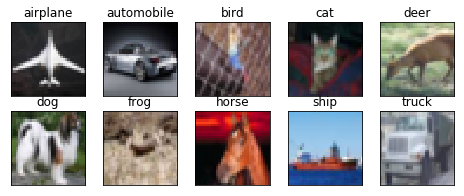

In [3]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

#### EXPLANATION

-  It predicts test results and take the maximum index value and so it means model predicted that index category.
-  Equate the results, sum it, divide and print the accuracy.

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

#### EXPLANATION
-  It usually reduce the resolution by half and increases the channels by four times, used while concatenate.

In [7]:
input = Input(shape=(img_rows,img_cols,img_channels,))

### NORMAL CONVOLUTION
#Layer 1
layer1 = Conv2D(32,(3,3),strides=(1,1),border_mode='same',name='conv_1',use_bias=False)(input) ## Receptive field : 3x3
layer1 = BatchNormalization(name='norm_1')(layer1)
layer1 = Activation('relu')(layer1)
layer1 = Dropout(0.1)(layer1)

### SPATIALLY SPERABLE CONVOLUTION
#Layer 2
layer2 = BatchNormalization(name='norm_2')(layer1)
layer2 = Conv2D(64, (3,1), strides=(1,1),name='conv_2',border_mode='same', use_bias=False)(layer2) ## Receptive field : 5x3
layer2 = Activation('relu')(layer2)
layer2 = Dropout(0.1)(layer2)

# Layer 3
layer3 = BatchNormalization(name='norm_3')(layer2)
layer3 = Conv2D(128, (1,3), strides=(1,1),name='conv_3',border_mode='same', use_bias=False)(layer3) ## Receptive field : 5x5
layer3 = Activation('relu')(layer3)
layer3 = Dropout(0.1)(layer3)

### TRANSITION LAYER
bottleneck1 = Conv2D(10,(1,1),strides=(1,1),name='bottleneck1',border_mode='same',use_bias=False)(layer3)
Maxpool1 = MaxPooling2D(pool_size=(2, 2))(bottleneck1) ## Receptive field : 10x10

### DEPTHWISE CONVOLUTION
# Layer 4
layer4 = BatchNormalization(name='norm_4')(Maxpool1)
layer4 = DepthwiseConv2D((3,3),padding='same')(layer4) ## Receptive field : 12x12
layer4 = Activation('relu')(layer4)
layer4 = Dropout(0.1)(layer4)

### GROUPED CONVOLUTION 1
# Layer 5
layer5 = BatchNormalization(name='norm_5')(layer4)
layer5 = Conv2D(32, (3,3), strides=(1,1),name='conv_5',border_mode='same', use_bias=False)(layer5) ## Receptive field : 14x14
layer5 = Activation('relu')(layer5)
layer5 = Dropout(0.1)(layer5)

# Layer 6
layer6 = BatchNormalization(name='norm_5')(layer4)
layer6 = Conv2D(64, (3,3), strides=(1,1),name='conv_5',border_mode='same', use_bias=False)(layer5) ## Receptive field : 14x14
layer6 = Activation('relu')(layer5)
layer6 = Dropout(0.1)(layer5)

# Layer 7
layer7 = concatenate([layer5, layer6])
bottleneck2 = Conv2D(10,(1,1),strides=(1,1),name='bottleneck2',border_mode='same',use_bias=False)(layer7) 
Maxpool2 = MaxPooling2D(pool_size=(2, 2))(bottleneck2)                                              ## Receptive field : 28x28

### GROUPED CONVOLUTION 2
# Layer 8
layer8 = BatchNormalization(name='norm_7')(Maxpool2)
layer8 = Conv2D(32, (3,3), strides=(1,1),name='conv_7',border_mode='same', use_bias=False, dilation_rate = 1)(layer8) ## Receptive field : 30x30
layer8 = Activation('relu')(layer8)
layer8 = Dropout(0.1)(layer8)

# Layer 9
layer9 = BatchNormalization(name='norm_8')(Maxpool2)
layer9 = Conv2D(64, (3,3), strides=(1,1),name='conv_8',border_mode='same', use_bias=False,dilation_rate = 2)(layer9) ## Receptive field : 32x32
layer9 = Activation('relu')(layer9)
layer9 = Dropout(0.1)(layer9)

layer10 = concatenate([layer8, layer9])

layer10 = Conv2D(10,(8,8),strides=(1,1),name='conv_10',use_bias=False)(layer10)
layer11 = Flatten()(layer10)

output = Activation('softmax')(layer11)


Instructions for updating:
Colocations handled automatically by placer.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), strides=(1, 1), name="conv_1", use_bias=False, padding="same")`
  after removing the cwd from sys.path.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 1), strides=(1, 1), name="conv_2", use_bias=False, padding="same")`
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (1, 3), strides=(1, 1), name="conv_3", use_bias=False, padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(10, (1, 1), strides=(1, 1), name="bottleneck1", use_bias=False, padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), strides=(1, 1), name="conv_5", use_bias=False, padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: UserWarning: Update your `Conv2D` call 

In [8]:
model = Model(inputs=[input], outputs=[output])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 32, 32, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
norm_1 (BatchNormalization)     (None, 32, 32, 32)   128         conv_1[0][0]                     
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 32)   0           norm_1[0][0]                     
__________________________________________________________________________________________________
dropout_1 

In [0]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=50)`
  if sys.path[0] == '':


Epoch 1/50
390/390 [==============================] - 21s 53ms/step - loss: 1.4360 - acc: 0.4809 - val_loss: 1.2934 - val_acc: 0.5497
Epoch 2/50
390/390 [==============================] - 18s 46ms/step - loss: 1.0978 - acc: 0.6107 - val_loss: 1.0927 - val_acc: 0.6182
Epoch 3/50
390/390 [==============================] - 18s 46ms/step - loss: 0.9566 - acc: 0.6627 - val_loss: 0.9434 - val_acc: 0.6680
Epoch 4/50
390/390 [==============================] - 18s 45ms/step - loss: 0.8589 - acc: 0.6971 - val_loss: 0.9406 - val_acc: 0.6694
Epoch 5/50
390/390 [==============================] - 18s 45ms/step - loss: 0.7943 - acc: 0.7214 - val_loss: 0.8353 - val_acc: 0.7131
Epoch 6/50
390/390 [==============================] - 18s 45ms/step - loss: 0.7357 - acc: 0.7414 - val_loss: 0.8649 - val_acc: 0.7017
Epoch 7/50
390/390 [==============================] - 18s 45ms/step - loss: 0.6924 - acc: 0.7596 - val_loss: 0.7943 - val_acc: 0.7245
Epoch 8/50
390/390 [==============================] - 18s 45ms

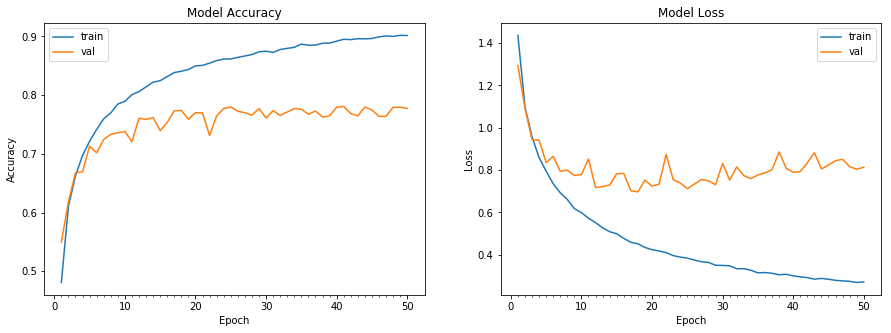

Accuracy on test data is: 77.74


In [10]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 50, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))